In [19]:
from random import *
import math
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

This simulation will take historical data and future data as list of lists or as csv-files. 
For this approach the  input should always match the output (days, months, points, sprints, tasks, projects)

Historical -> a list of lists that we pass with: 
Task/Project Id, 
Original Estimate(months, days, points, sprints)
Actual Estimate (months, days, points, sprints)

Future -> a list of lists that passes through
Task/Project Id, 
Predicted Estimation (months, days, points, sprints)


In [30]:
def runSingleSimulation(historical,future,n=10**5 ):
    '''
    Runs a single simulation of future data based on historical data.
    Input: historical = list of lists in the format: [[TaskName, estimated, actual], ...]
            future = list of lists in the format: [[TaskName, estimated], ...]
    '''
    estimatedTotal=0
    for task in future:
        selectedEvent = historical[randint(0,len(historical)-1)]
        velocity = int(float(selectedEvent[2]))/int(float(selectedEvent[1]))
        estimated = velocity*task[1]
        estimatedTotal+=estimated
        task.append(estimated)
    estimatedTotal=round(estimatedTotal,2)
    #estimatedTotal=math.ceil(estimatedTotal/110) 
    return (estimatedTotal)


In [37]:
def runSimulations(historical,future,n=10**5,verbose=False):
    '''
            Runs n simulations of future data based on historical data.
            Input: historical = list of lists in the format: [[ProjectName, estimated, actual], ...]
            future = list of lists in the format: [[ProjectName, estimated], ...]
            n = number of simulations to run
    '''
    estTotalMult=0
    estimations=[]
    for task in future:
        estTotalMult+=task[1]
    print("Estimated Total: "+str(estTotalMult))
    for i in range(0,n):
        estimatedTotal = runSingleSimulation(historical,future)
        estimations.append(estimatedTotal)
        if (verbose):
            print ("Trial {0:2} prediction: {1:.2f} ({2:.2f}% of estimated)".format(i,estimatedTotal,100*estimatedTotal/estTotalMult))
    print("Min:{0:.2f} ({1:.2f}% of estimated)\nMax:{2:.2f} ({3:.2f}% of estimated)".format(min(estimations),100*min(estimations)/estTotalMult,max(estimations),100*max(estimations)/estTotalMult))
    return(sorted(estimations))

In [46]:
#data = runSingleSimulation([['Project_1', 4, 3], ['Project_2', 2, 3], ['Project_3', 4, 5]], [['Projected_project', 3],])
#print(data)
data = runSimulations([['Project_1', 4, 3], ['Project_2', 2, 3], ['Project_3', 4, 5]], [['Projected_project', 3],])

Estimated Total: 3
Min:2.25 (75.00% of estimated)
Max:4.50 (150.00% of estimated)


In [47]:
def loadFile(historicalFilename, futureFilename, verbose=False, historicalType='task'):
    '''Input: historicalFilename, futureFilename
            Optional: Verbose, historicalType("task" or "sprint")
        Output: historical, future'''
    
    historical = []
    future = []
    hasHeaders=False
    
    with open(historicalFilename) as csvfile:
        sample = csvfile.read(1024)
        sniffer = csv.Sniffer()
        hasHeaders = csv.Sniffer().has_header(sample)
        dialect = sniffer.sniff(sample)
        csvfile.seek(0)
        reader = csv.reader(csvfile, dialect)
        firstLine=True
        for row in reader:
            if (hasHeaders and firstLine):
                firstLine=False
            else:
                historical.append(row)
        if (verbose):
            print("Loaded {0} historical items".format(len(historical)))
            
    with open(futureFilename) as csvfile:
        sample = csvfile.read(1024)
        hasHeaders =csv.Sniffer().has_header(sample)
        dialect = sniffer.sniff(sample)
        csvfile.seek(0)
        reader = csv.reader(csvfile, dialect)
        firstLine=True
        for row in reader:
            if(hasHeaders and firstLine):
                firstLine=False
            else:
                future.append([row[0], int(row[1])])
                
    if (verbose):
        print("Loaded {0} future items".format(len(future)))
    return(historical, future)

To get expanded unsorted results of n simulations, change 'verbose' to 'True'

In [48]:
def summary(data,verbose=False):
    '''
    Input: prediction data after running runSimulations()
    Output: List of lists estimations and their counts: [[estimation, count], [estimation, count]...]
    '''
    
    points = []
    output=[]
    for p in data:
        if (p not in points):
            points.append(p)
    for p in points:
        c = data.count(p)
        output.append([p,c])
    return(output)

Format of the project input is ['Project_name', estimated, actual], where the last project in a list should be the one you actually need to simulate. For the simulated project, the input format is ['Project_name', 3].

The format of input is equal to the format of the output, depending on how your team plans the velocity (engineer months, weeks, sprints etc)

The cell below illustrates the data we are working with. It gives an upper and lower bound of the potential deviation based on how the final cost deviated from the original estimated ('projects_historic.csv'). The output here will print the original estimate of the project we want to simulate (***Estimated Total: 76***)

The next two entries will output Min and Max deviation based on the historical data. 
***What does this mean?*** This means that based on the historical data, final cost of the projects were between 33% to 550% of the original estimate. The simulation will use it as a runaway for estimating the future project. 

In [49]:
files = loadFile('projects_historic.csv', 'projects_future.csv')

estimation = runSimulations(data[0], data[1])
summary(estimation)
print(round(np.percentile(estimation,95),2))

TypeError: 'float' object is not iterable

(array([0.00548142, 0.00420916, 0.00818372, 0.00815267, 0.00561425,
        0.00413028, 0.00267939, 0.00274606, 0.00559288, 0.00273791,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00136285]),
 array([ 25.  ,  44.65,  64.3 ,  83.95, 103.6 , 123.25, 142.9 , 162.55,
        182.2 , 201.85, 221.5 , 241.15, 260.8 , 280.45, 300.1 , 319.75,
        339.4 , 359.05, 378.7 , 398.35, 418.  ]),
 <BarContainer object of 20 artists>)

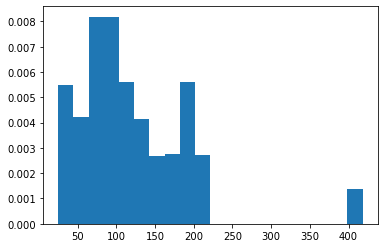

In [45]:
list_of_single_simulations = []

for i in range(10**5):
    single_estimation = round(runSingleSimulation(files[0], files[1]))
    list_of_single_simulations.append(single_estimation)

num_bins = 20
plt.hist(list_of_single_simulations,num_bins, density = 1, stacked=True)


<AxesSubplot:ylabel='Density'>

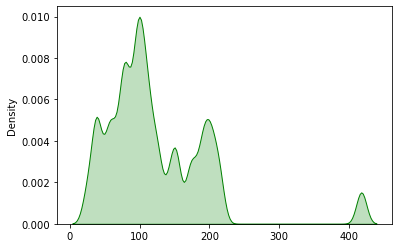

In [96]:
sns.kdeplot(list_of_single_simulations, shade=True, color="g")